# Gender Model

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TicketPrefix" data-toc-modified-id="TicketPrefix-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TicketPrefix</a></span></li></ul></div>

In [1]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from category_encoders.count import CountEncoder
from category_encoders.m_estimate import MEstimateEncoder

from feature_engine.creation import MathFeatures
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.imputation import AddMissingIndicator, RandomSampleImputer
from feature_engine.selection import DropCorrelatedFeatures, DropFeatures
from feature_engine.transformation import LogCpTransformer

from joblib import load
from matplotlib import pyplot as plt
import numpy as np
import optuna
from optuna.integration import CatBoostPruningCallback
import pandas as pd
import seaborn as sns
import shap
import sklearn
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

CV=5
N_JOBS = -1
N_TRIALS = 1000

sklearn.set_config(transform_output="pandas")

%matplotlib inline

In [2]:
X_train, y_train = load("train_set.joblib")
X_test, y_test = load("test_set.joblib")

In [3]:
cat_cols = [
    'Age_discr',
    'Age_na',
    'Cabin',
    'Cabin_na',
    'Deck',
    'Embarked',
    'Fare_discr',
    'Pclass',
#     'Sex',
    'Surname',
    'Ticket',
    'TicketPrefix',
    'Title'
]

num_cols = [
    'Age',
    'Fare',
    'SibSp',
    'Parch',
    'prod_Age_Fare',
    'Family',
    'FareAgeRatio',
    'ParchFamilyRatio',
    'SibSpFamilyRatio',
]


def add_surname(X, y=None):
    return X.assign(Surname=X.Name.str.split(',').str[0].str.lower())
    
surname_adder = FunctionTransformer(add_surname)


def add_title(X, y=None, group_rare=True):
    title = X.Name.str.extract(pat=r"\b,\s(.+?)\.\s[\b(]?")
    title = pd.Series(title[0], name="Title").str.lower()

    if group_rare:
        title = title.where(
            title.isin(["mr", "miss", "mrs", "master"]), "aristocratic"
        )

    return pd.concat([X, title], axis="columns")

title_adder = FunctionTransformer(add_title)


missing_indicator = AddMissingIndicator(
    variables=['Age', 'Cabin']
)


random_imputer = RandomSampleImputer(
    variables=['Age', 'Embarked', 'Fare']
)


cabin_imputer = FunctionTransformer(
    lambda x: x.assign(Cabin=lambda x: x.Cabin.fillna('unknown'))
)


def get_deck(X, y=None):
    res = X.copy()
    res['Deck'] = res.Cabin.copy()
    res['Deck'] = res['Deck'].str.replace(pat=r'.*?([a-zA-z]+).*', repl=r'\1', regex=True).str.lower()
    
    return res

deck_finder = FunctionTransformer(get_deck)


class Discretizer(BaseEstimator, TransformerMixin):
    def __init__(self, q=10, cols=['Age', 'Fare']):
        self.q = q
        self.cols = cols
        
    def fit(self, X, y=None):
        self.discr = EqualFrequencyDiscretiser(q=self.q).fit(X[self.cols])
        return self
    
    
    def transform(self, X, y=None):
        res = X.copy()
        new_names = [f'{col}_discr' for col in self.cols]
        res[new_names] = self.discr.transform(X[self.cols])
        return res

discretizer = Discretizer(q=5)


age_fare_mult = FunctionTransformer(
    lambda x: x.assign(prod_Age_Fare=x.Age * x.Fare)
)


family_adder = FunctionTransformer(
    lambda X: X.assign(Family=X.SibSp + X.Parch + 1)
)


fare_age_ratio_adder = FunctionTransformer(
    lambda X: X.assign(FareAgeRatio=X.Fare / (X.Age + 1))
)


parch_family_ratio_adder = FunctionTransformer(
    lambda X: X.assign(ParchFamilyRatio=X.Parch / X.Family)
)


sibsp_family_ratio_adder = FunctionTransformer(
    lambda X: X.assign(SibSpFamilyRatio=X.SibSp / X.Family)
)


def get_ticket_prefix(X, y=None):
    res = X.copy()  
    res['TicketPrefix'] = res['Ticket'].str.split().str[0].str.lower()
    res.loc[res['TicketPrefix'].str.isnumeric(), 'TicketPrefix'] = 'numeric'
    return res

ticket_prefixer = FunctionTransformer(get_ticket_prefix)


num_scaler = ColumnTransformer(
    [('scaler', StandardScaler(), num_cols)], 
    remainder='passthrough',
    verbose_feature_names_out=False,
)

drop_cols = DropFeatures(
    features_to_drop=['PassengerId', 'Name']
)

In [4]:
class GenderModel(BaseEstimator, ClassifierMixin):
    def __init__(self, male_model_params, female_model_params):
        self.male_model_params = male_model_params
        self.female_model_params = female_model_params
            
            
    def fit(self, X, y=None):       
        data_prep = Pipeline([
            ('surname', surname_adder),
            ('title', title_adder),
            ('missing_indicator', missing_indicator),
            ('rnd_imputer', random_imputer),
            ('cabin_imputer', cabin_imputer),
            ('deck', deck_finder),
            ('discretizer', discretizer),
            ('multiplier', age_fare_mult),
            ('family', family_adder),
            ('family_age_ratio', fare_age_ratio_adder),
            ('parch_family_ratio', parch_family_ratio_adder),
            ('sibsp_family_ratio', sibsp_family_ratio_adder),
            ('ticket_pref', ticket_prefixer),
            ('num_cols_scaler', num_scaler),
            ('drop', drop_cols),
        ])
        
        self.male_model = Pipeline([
            ('data_prep', data_prep),
            ('encoder', MEstimateEncoder(m=self.male_model_params['m'], cols=cat_cols)),
            ('scaler', StandardScaler()),
            ('classifier', 
             LogisticRegression(penalty=self.male_model_params['penalty'], 
                                C=self.male_model_params['C'], 
                                solver='liblinear'
                               )
            )
        ])
              
        self.female_model = Pipeline([
            ('data_prep', data_prep),
            ('encoder', MEstimateEncoder(m=self.female_model_params['m'], cols=cat_cols)),
            ('scaler', StandardScaler()),
            ('classifier', 
             LogisticRegression(penalty=self.female_model_params['penalty'], 
                                C=self.female_model_params['C'], 
                                solver='liblinear'
                               )
            )
        ])
        
        
        male_X = X.query("Sex == 'male'").drop(columns='Sex')
        male_y = y[male_X.index].drop(columns='Sex')
        self.male_model.fit(male_X, male_y)
        
        female_X = X.query("Sex == 'female'").drop(columns='Sex')
        female_y = y[female_X.index].drop(columns='Sex')
        self.female_model.fit(female_X, female_y)

        return self
        

    def predict(self, X):
        
        index = X.index
        
        female = X.query('Sex == "female"').drop(columns='Sex')
        male = X.query('Sex == "male"').drop(columns='Sex')
        
        female['y_pred'] = self.female_model.predict(female)
        male['y_pred'] = self.male_model.predict(male)
        
        return pd.concat([female, male]).loc[index, 'y_pred']

In [5]:
def objective(trial):
    male_model_params = {
        'penalty': trial.suggest_categorical('male_penalty', ['l1', 'l2']),
        'C': trial.suggest_float('male_C', 0.01, 10, log=True),
        'm': trial.suggest_float('male_m', 0.01, 10, log=True),
    }
    
    female_model_params = {
        'penalty': trial.suggest_categorical('female_penalty', ['l1', 'l2']),
        'C': trial.suggest_float('female_C', 0.01, 10, log=True),
        'm': trial.suggest_float('female_m', 0.01, 10, log=True),
    }
    
    model = GenderModel(male_model_params, female_model_params)
    
    scores = cross_val_score(
        estimator=model,
        X=X_train,
        y=y_train,
        scoring='accuracy',
        cv=CV,
        n_jobs=-1,
    )
    
    return scores.mean()


study = optuna.create_study(
    direction='maximize'
)
study.optimize(objective, n_trials=N_TRIALS)

[I 2023-11-14 15:02:25,865] A new study created in memory with name: no-name-5eed84ba-cc08-460e-8ebb-d232c4f2df4a
[I 2023-11-14 15:02:26,891] Trial 0 finished with value: 0.8118388653599922 and parameters: {'male_penalty': 'l1', 'male_C': 2.3592091709565675, 'male_m': 0.01114046724455275, 'female_penalty': 'l1', 'female_C': 4.53459919581219, 'female_m': 0.05755648488944139}. Best is trial 0 with value: 0.8118388653599922.
[I 2023-11-14 15:02:27,599] Trial 1 finished with value: 0.8090318132571654 and parameters: {'male_penalty': 'l1', 'male_C': 0.20022928735380494, 'male_m': 0.22438620741616927, 'female_penalty': 'l1', 'female_C': 0.18993195513693387, 'female_m': 0.05056206107789799}. Best is trial 0 with value: 0.8118388653599922.
[I 2023-11-14 15:02:27,849] Trial 2 finished with value: 0.8132276174529697 and parameters: {'male_penalty': 'l1', 'male_C': 0.1989062945297437, 'male_m': 8.362894622585289, 'female_penalty': 'l1', 'female_C': 0.3755070789124686, 'female_m': 1.67376173438349

[I 2023-11-14 15:02:33,930] Trial 25 finished with value: 0.818851570964247 and parameters: {'male_penalty': 'l2', 'male_C': 0.010675870075003082, 'male_m': 2.2379512101655266, 'female_penalty': 'l2', 'female_C': 0.47101360886839705, 'female_m': 0.019010355864993406}. Best is trial 19 with value: 0.8202698709740963.
[I 2023-11-14 15:02:34,203] Trial 26 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.029042873327708843, 'male_m': 5.197444750404452, 'female_penalty': 'l2', 'female_C': 0.6612464081654473, 'female_m': 0.03697934725492432}. Best is trial 26 with value: 0.8216684723726978.
[I 2023-11-14 15:02:34,452] Trial 27 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.027345861160685894, 'male_m': 9.856945739653051, 'female_penalty': 'l2', 'female_C': 0.5060324581470238, 'female_m': 0.036619512205220146}. Best is trial 26 with value: 0.8216684723726978.
[I 2023-11-14 15:02:34,685] Trial 28 finished wit

[I 2023-11-14 15:02:40,666] Trial 50 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.06396080644845624, 'male_m': 1.1564280388460197, 'female_penalty': 'l1', 'female_C': 1.3346363264576644, 'female_m': 0.015444592020466877}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:02:40,962] Trial 51 finished with value: 0.8202600216684723 and parameters: {'male_penalty': 'l2', 'male_C': 0.038445265695777636, 'male_m': 1.8426717710751703, 'female_penalty': 'l1', 'female_C': 0.6886180110079291, 'female_m': 0.028811602030203005}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:02:41,207] Trial 52 finished with value: 0.8202797202797203 and parameters: {'male_penalty': 'l2', 'male_C': 0.022338781635445063, 'male_m': 2.574375762493668, 'female_penalty': 'l1', 'female_C': 0.7123679881469279, 'female_m': 0.022510274910252044}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:02:41,454] Trial 53 finished wi

[I 2023-11-14 15:02:47,068] Trial 75 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.01014539755389247, 'male_m': 1.2539304973565144, 'female_penalty': 'l1', 'female_C': 0.32214107894141525, 'female_m': 0.01172872201707336}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:02:47,352] Trial 76 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.03178392658633412, 'male_m': 3.378471312594733, 'female_penalty': 'l1', 'female_C': 0.9424663823075252, 'female_m': 0.020951384847755754}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:02:47,591] Trial 77 finished with value: 0.8188712695754949 and parameters: {'male_penalty': 'l2', 'male_C': 0.017361799931149703, 'male_m': 1.4722808861857715, 'female_penalty': 'l1', 'female_C': 0.5322046350000167, 'female_m': 0.04476152392607755}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:02:47,831] Trial 78 finished with

[I 2023-11-14 15:02:53,492] Trial 100 finished with value: 0.8202600216684726 and parameters: {'male_penalty': 'l2', 'male_C': 0.06158916694755118, 'male_m': 4.479451113665295, 'female_penalty': 'l1', 'female_C': 0.19336966693549573, 'female_m': 0.029768006639709643}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:02:53,778] Trial 101 finished with value: 0.8230769230769232 and parameters: {'male_penalty': 'l2', 'male_C': 0.025638442829034883, 'male_m': 3.06082070395022, 'female_penalty': 'l1', 'female_C': 0.28437968828530186, 'female_m': 0.021468583416856965}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:02:54,130] Trial 102 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.03659191479160389, 'male_m': 5.745292896459783, 'female_penalty': 'l1', 'female_C': 0.24969787307354613, 'female_m': 0.016971201788604028}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:02:54,363] Trial 103 finished

[I 2023-11-14 15:03:00,381] Trial 125 finished with value: 0.8216783216783217 and parameters: {'male_penalty': 'l2', 'male_C': 0.04082036300647486, 'male_m': 3.6185180216786508, 'female_penalty': 'l1', 'female_C': 0.17954983717789158, 'female_m': 0.03258994890623781}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:00,616] Trial 126 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.029228687487547114, 'male_m': 2.536946376549969, 'female_penalty': 'l1', 'female_C': 0.2438000676914623, 'female_m': 0.01612291550350575}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:00,860] Trial 127 finished with value: 0.8216783216783217 and parameters: {'male_penalty': 'l2', 'male_C': 0.022133969385439257, 'male_m': 2.8459921768214786, 'female_penalty': 'l1', 'female_C': 0.2827506893232536, 'female_m': 0.02220437731594249}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:01,113] Trial 128 finished 

[I 2023-11-14 15:03:07,015] Trial 150 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.023548135057376435, 'male_m': 2.693423391852876, 'female_penalty': 'l1', 'female_C': 1.1086409712158447, 'female_m': 0.045776480172825706}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:07,269] Trial 151 finished with value: 0.8202600216684723 and parameters: {'male_penalty': 'l2', 'male_C': 0.04086464126264075, 'male_m': 4.781496673434756, 'female_penalty': 'l1', 'female_C': 0.31233980448492454, 'female_m': 0.01713314836981368}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:07,533] Trial 152 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.03969837822545525, 'male_m': 4.292525483793442, 'female_penalty': 'l1', 'female_C': 0.2869697617730929, 'female_m': 0.013638119194025902}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:07,783] Trial 153 finished w

[I 2023-11-14 15:03:13,621] Trial 175 finished with value: 0.8202600216684723 and parameters: {'male_penalty': 'l2', 'male_C': 0.027488882408637807, 'male_m': 3.191376279646665, 'female_penalty': 'l1', 'female_C': 0.37969637856293353, 'female_m': 0.021111055758886114}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:13,894] Trial 176 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.032237630798089965, 'male_m': 5.623538805141373, 'female_penalty': 'l1', 'female_C': 0.24647610090254887, 'female_m': 0.02762186285983567}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:14,132] Trial 177 finished with value: 0.8188515709642472 and parameters: {'male_penalty': 'l2', 'male_C': 0.05408956853839857, 'male_m': 7.632670272974448, 'female_penalty': 'l1', 'female_C': 0.29060996612634316, 'female_m': 0.01519407964211636}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:14,420] Trial 178 finished

[I 2023-11-14 15:03:20,248] Trial 200 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.015500001714549322, 'male_m': 2.784251368533511, 'female_penalty': 'l1', 'female_C': 0.5292966545435311, 'female_m': 0.02562893985783459}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:20,556] Trial 201 finished with value: 0.8216783216783217 and parameters: {'male_penalty': 'l2', 'male_C': 0.019681357037540727, 'male_m': 5.379612974003884, 'female_penalty': 'l1', 'female_C': 0.14017302209024637, 'female_m': 0.03265349750522087}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:20,810] Trial 202 finished with value: 0.8230769230769232 and parameters: {'male_penalty': 'l2', 'male_C': 0.02987893951784586, 'male_m': 3.7414840981009982, 'female_penalty': 'l1', 'female_C': 0.1212531858390353, 'female_m': 0.04421987127042772}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:21,124] Trial 203 finished w

[I 2023-11-14 15:03:26,946] Trial 225 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.030661067748262265, 'male_m': 4.35034594044361, 'female_penalty': 'l1', 'female_C': 1.6700429874140352, 'female_m': 0.10633335577674502}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:27,205] Trial 226 finished with value: 0.8216586230670739 and parameters: {'male_penalty': 'l2', 'male_C': 0.017347485383364423, 'male_m': 7.251038218957388, 'female_penalty': 'l1', 'female_C': 0.1266495209432185, 'female_m': 0.03146676980012983}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:27,455] Trial 227 finished with value: 0.8188712695754949 and parameters: {'male_penalty': 'l2', 'male_C': 0.025968329515640223, 'male_m': 2.414658408245401, 'female_penalty': 'l1', 'female_C': 0.2605342140521391, 'female_m': 0.026942465130524437}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:27,795] Trial 228 finished wi

[I 2023-11-14 15:03:33,402] Trial 250 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.0140224918315494, 'male_m': 3.304023579740131, 'female_penalty': 'l1', 'female_C': 0.2756925269511513, 'female_m': 0.04619753448512501}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:33,644] Trial 251 finished with value: 0.8230769230769232 and parameters: {'male_penalty': 'l2', 'male_C': 0.030690442643734328, 'male_m': 5.679083450827432, 'female_penalty': 'l1', 'female_C': 0.16753590084067757, 'female_m': 0.016771517792960076}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:33,889] Trial 252 finished with value: 0.8188515709642472 and parameters: {'male_penalty': 'l2', 'male_C': 0.2575414857516233, 'male_m': 4.525995849366361, 'female_penalty': 'l1', 'female_C': 0.24449526310541225, 'female_m': 0.011393951590072431}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:34,141] Trial 253 finished wi

[I 2023-11-14 15:03:40,020] Trial 275 finished with value: 0.8202600216684723 and parameters: {'male_penalty': 'l2', 'male_C': 0.01764442734888996, 'male_m': 9.813140338688006, 'female_penalty': 'l1', 'female_C': 0.18436181074570818, 'female_m': 0.03698948390221361}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:40,266] Trial 276 finished with value: 0.8132276174529697 and parameters: {'male_penalty': 'l1', 'male_C': 0.026530502363918178, 'male_m': 7.831862301083928, 'female_penalty': 'l1', 'female_C': 0.8260092820486972, 'female_m': 0.022302986968061895}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:40,527] Trial 277 finished with value: 0.8202600216684726 and parameters: {'male_penalty': 'l2', 'male_C': 0.05059995243279855, 'male_m': 5.260771782921553, 'female_penalty': 'l1', 'female_C': 0.29314566280286164, 'female_m': 0.030497123821056904}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:40,771] Trial 278 finished 

[I 2023-11-14 15:03:46,883] Trial 300 finished with value: 0.8216783216783217 and parameters: {'male_penalty': 'l2', 'male_C': 0.025231956488408057, 'male_m': 4.344845627456336, 'female_penalty': 'l1', 'female_C': 1.5601313998294448, 'female_m': 0.024918140127488792}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:47,213] Trial 301 finished with value: 0.8230769230769232 and parameters: {'male_penalty': 'l2', 'male_C': 0.03316544806667339, 'male_m': 5.985720530267388, 'female_penalty': 'l1', 'female_C': 0.12148261341301177, 'female_m': 0.016191101421961545}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:47,483] Trial 302 finished with value: 0.8174628188712696 and parameters: {'male_penalty': 'l2', 'male_C': 0.017558814083508404, 'male_m': 8.110178690477028, 'female_penalty': 'l1', 'female_C': 0.24821908797755535, 'female_m': 0.030515488851373056}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:47,730] Trial 303 finishe

[I 2023-11-14 15:03:53,747] Trial 325 finished with value: 0.8160642174726682 and parameters: {'male_penalty': 'l2', 'male_C': 0.03165520524566235, 'male_m': 0.6372585233267971, 'female_penalty': 'l1', 'female_C': 0.08531405239790898, 'female_m': 0.021002486285537195}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:54,003] Trial 326 finished with value: 0.8188515709642472 and parameters: {'male_penalty': 'l2', 'male_C': 1.4869957338071276, 'male_m': 5.187241263648101, 'female_penalty': 'l1', 'female_C': 0.8957781908573837, 'female_m': 0.016544037116028358}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:54,247] Trial 327 finished with value: 0.8188515709642472 and parameters: {'male_penalty': 'l2', 'male_C': 0.3698508787530255, 'male_m': 2.352602059225984, 'female_penalty': 'l1', 'female_C': 0.10570920974906872, 'female_m': 0.3053080262440763}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:03:54,487] Trial 328 finished wit

[I 2023-11-14 15:04:00,257] Trial 350 finished with value: 0.8188614202698709 and parameters: {'male_penalty': 'l2', 'male_C': 0.021142202905883683, 'male_m': 8.0123557058044, 'female_penalty': 'l1', 'female_C': 5.476884902425213, 'female_m': 2.948635290139969}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:00,504] Trial 351 finished with value: 0.8202797202797203 and parameters: {'male_penalty': 'l2', 'male_C': 0.01634831679387706, 'male_m': 0.8249440427816093, 'female_penalty': 'l1', 'female_C': 1.5784556364118445, 'female_m': 0.03646835027054096}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:00,757] Trial 352 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.04460533005133234, 'male_m': 1.7483225253525416, 'female_penalty': 'l1', 'female_C': 0.14671851083570692, 'female_m': 0.024258588106428208}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:00,997] Trial 353 finished with 

[I 2023-11-14 15:04:06,779] Trial 375 finished with value: 0.8188515709642472 and parameters: {'male_penalty': 'l2', 'male_C': 0.2379837164186814, 'male_m': 3.4510915506440276, 'female_penalty': 'l1', 'female_C': 0.8156035353975168, 'female_m': 0.10361160845195548}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:07,016] Trial 376 finished with value: 0.8216586230670739 and parameters: {'male_penalty': 'l2', 'male_C': 0.014681502209926166, 'male_m': 2.9167718495505333, 'female_penalty': 'l2', 'female_C': 0.5986493440495194, 'female_m': 0.01952413974400171}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:07,329] Trial 377 finished with value: 0.8216783216783217 and parameters: {'male_penalty': 'l2', 'male_C': 0.028982712074909135, 'male_m': 7.307621000250434, 'female_penalty': 'l1', 'female_C': 0.21066997330074919, 'female_m': 0.05503474102450139}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:07,570] Trial 378 finished w

[I 2023-11-14 15:04:13,425] Trial 400 finished with value: 0.8188515709642472 and parameters: {'male_penalty': 'l2', 'male_C': 0.11101164878474523, 'male_m': 5.389073547969867, 'female_penalty': 'l1', 'female_C': 0.6924730323986011, 'female_m': 0.030279562634757385}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:13,764] Trial 401 finished with value: 0.8202797202797203 and parameters: {'male_penalty': 'l2', 'male_C': 0.028299346623856966, 'male_m': 0.35347877365375846, 'female_penalty': 'l1', 'female_C': 0.1456880075133084, 'female_m': 0.018826416468210407}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:14,042] Trial 402 finished with value: 0.8188614202698709 and parameters: {'male_penalty': 'l2', 'male_C': 0.04676606164380156, 'male_m': 6.221931785951841, 'female_penalty': 'l1', 'female_C': 0.8986362561789816, 'female_m': 0.010036993175685866}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:14,280] Trial 403 finished

[I 2023-11-14 15:04:20,316] Trial 425 finished with value: 0.8174529695656456 and parameters: {'male_penalty': 'l2', 'male_C': 0.1637520050610293, 'male_m': 0.7559953497747411, 'female_penalty': 'l1', 'female_C': 3.1982851460389914, 'female_m': 0.02507890094387435}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:20,554] Trial 426 finished with value: 0.8216783216783217 and parameters: {'male_penalty': 'l2', 'male_C': 0.031215547182894748, 'male_m': 8.606592440308825, 'female_penalty': 'l1', 'female_C': 1.599582403582915, 'female_m': 0.019471366148101747}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:20,794] Trial 427 finished with value: 0.8188811188811188 and parameters: {'male_penalty': 'l2', 'male_C': 0.019289841275561298, 'male_m': 4.162781041990505, 'female_penalty': 'l1', 'female_C': 0.09334255326865572, 'female_m': 0.11640343431954864}. Best is trial 43 with value: 0.8244853737811484.
[I 2023-11-14 15:04:21,077] Trial 428 finished wi

[I 2023-11-14 15:04:27,055] Trial 450 finished with value: 0.8202501723628485 and parameters: {'male_penalty': 'l2', 'male_C': 0.4891273715824972, 'male_m': 4.84705193087043, 'female_penalty': 'l1', 'female_C': 0.329858135404036, 'female_m': 0.033071301993004565}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:27,298] Trial 451 finished with value: 0.8174529695656456 and parameters: {'male_penalty': 'l2', 'male_C': 0.09413045662629944, 'male_m': 1.9102056893913664, 'female_penalty': 'l1', 'female_C': 0.8947024115387942, 'female_m': 0.23784962164788367}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:27,538] Trial 452 finished with value: 0.8174529695656456 and parameters: {'male_penalty': 'l2', 'male_C': 0.2183740232727444, 'male_m': 1.1391176363547484, 'female_penalty': 'l1', 'female_C': 0.1160955856231463, 'female_m': 0.02427079453905133}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:27,777] Trial 453 finished wit

[I 2023-11-14 15:04:33,758] Trial 475 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.017759648119927078, 'male_m': 6.464693886013712, 'female_penalty': 'l1', 'female_C': 0.08430988408120818, 'female_m': 0.011512083400238543}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:34,033] Trial 476 finished with value: 0.8160445188614203 and parameters: {'male_penalty': 'l2', 'male_C': 4.148738800699531, 'male_m': 7.241793396980073, 'female_penalty': 'l1', 'female_C': 0.08345994060890535, 'female_m': 0.011479222992716757}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:34,275] Trial 477 finished with value: 0.8132473160642176 and parameters: {'male_penalty': 'l2', 'male_C': 1.9636119855726295, 'male_m': 0.02167594693653789, 'female_penalty': 'l1', 'female_C': 1.018759105533555, 'female_m': 0.38747229189232363}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:34,527] Trial 478 finished

[I 2023-11-14 15:04:40,556] Trial 500 finished with value: 0.8160445188614203 and parameters: {'male_penalty': 'l2', 'male_C': 0.08225331512282161, 'male_m': 3.628816991006194, 'female_penalty': 'l1', 'female_C': 6.707019860573444, 'female_m': 0.01546298894722112}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:40,828] Trial 501 finished with value: 0.8216783216783217 and parameters: {'male_penalty': 'l2', 'male_C': 0.023740683011868574, 'male_m': 2.3840451920338412, 'female_penalty': 'l1', 'female_C': 1.2521056787420162, 'female_m': 0.02218092939584462}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:41,162] Trial 502 finished with value: 0.8188417216586231 and parameters: {'male_penalty': 'l2', 'male_C': 0.15485136586625545, 'male_m': 4.634964665878051, 'female_penalty': 'l1', 'female_C': 0.15109329877627373, 'female_m': 0.011143437667650517}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:41,425] Trial 503 finished

[I 2023-11-14 15:04:47,238] Trial 525 finished with value: 0.8188712695754949 and parameters: {'male_penalty': 'l2', 'male_C': 0.02382933875185149, 'male_m': 3.6488305750154657, 'female_penalty': 'l1', 'female_C': 0.06009606495712272, 'female_m': 9.626763562687536}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:47,484] Trial 526 finished with value: 0.8202501723628485 and parameters: {'male_penalty': 'l2', 'male_C': 0.6414413584896405, 'male_m': 1.936859567217098, 'female_penalty': 'l1', 'female_C': 0.07659589429162335, 'female_m': 0.021724612989495618}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:47,757] Trial 527 finished with value: 0.8090318132571654 and parameters: {'male_penalty': 'l1', 'male_C': 0.35476598833019407, 'male_m': 0.2107429455473989, 'female_penalty': 'l1', 'female_C': 0.24699904057846328, 'female_m': 0.6167718343209073}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:48,004] Trial 528 finished 

[I 2023-11-14 15:04:53,903] Trial 550 finished with value: 0.8174726681768936 and parameters: {'male_penalty': 'l2', 'male_C': 0.07734171655817437, 'male_m': 0.5128644151955829, 'female_penalty': 'l1', 'female_C': 0.043035641357983885, 'female_m': 2.302546055713968}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:54,141] Trial 551 finished with value: 0.8202797202797203 and parameters: {'male_penalty': 'l2', 'male_C': 0.021311134428767562, 'male_m': 5.941173532128384, 'female_penalty': 'l2', 'female_C': 0.17584542762543837, 'female_m': 0.017926056844741543}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:54,385] Trial 552 finished with value: 0.8202600216684723 and parameters: {'male_penalty': 'l2', 'male_C': 0.011603957975950787, 'male_m': 6.806787722646421, 'female_penalty': 'l1', 'female_C': 0.9785144570566, 'female_m': 0.020686848599652148}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:04:54,626] Trial 553 finished

[I 2023-11-14 15:05:00,494] Trial 575 finished with value: 0.8174628188712696 and parameters: {'male_penalty': 'l2', 'male_C': 0.044628103700237884, 'male_m': 1.0936969002476338, 'female_penalty': 'l1', 'female_C': 0.022686260662064393, 'female_m': 4.003146260013496}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:00,741] Trial 576 finished with value: 0.8104402639613909 and parameters: {'male_penalty': 'l2', 'male_C': 1.0641482073419157, 'male_m': 0.012910645856464351, 'female_penalty': 'l1', 'female_C': 0.11718320929208538, 'female_m': 0.13290783762292704}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:00,987] Trial 577 finished with value: 0.8160740667782921 and parameters: {'male_penalty': 'l2', 'male_C': 0.02491983436857855, 'male_m': 0.22420723331821282, 'female_penalty': 'l1', 'female_C': 0.31917079585715336, 'female_m': 0.011468885601436133}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:01,289] Trial 578 fi

[I 2023-11-14 15:05:07,240] Trial 600 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.021306515420177013, 'male_m': 7.521920965282996, 'female_penalty': 'l1', 'female_C': 1.9532795233403963, 'female_m': 0.2558262853412543}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:07,550] Trial 601 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.013427485578505462, 'male_m': 7.669156834512101, 'female_penalty': 'l1', 'female_C': 3.622141719180133, 'female_m': 0.10516228193474852}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:07,793] Trial 602 finished with value: 0.8174825174825175 and parameters: {'male_penalty': 'l2', 'male_C': 0.026340007022014153, 'male_m': 0.08618849830047393, 'female_penalty': 'l1', 'female_C': 2.155626318847916, 'female_m': 1.5043006962888095}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:08,139] Trial 603 finished w

[I 2023-11-14 15:05:14,312] Trial 625 finished with value: 0.8132571653698413 and parameters: {'male_penalty': 'l2', 'male_C': 0.08200652202481472, 'male_m': 0.2942827696162321, 'female_penalty': 'l1', 'female_C': 0.20948738663189342, 'female_m': 0.01669492035490137}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:14,570] Trial 626 finished with value: 0.8146459174628189 and parameters: {'male_penalty': 'l2', 'male_C': 7.14240502925271, 'male_m': 5.547450671237114, 'female_penalty': 'l1', 'female_C': 4.006711582206925, 'female_m': 0.06772487402644078}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:14,840] Trial 627 finished with value: 0.8174628188712696 and parameters: {'male_penalty': 'l2', 'male_C': 0.017214349127050787, 'male_m': 1.1963379185800778, 'female_penalty': 'l2', 'female_C': 0.24773021108722384, 'female_m': 0.19235010630715846}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:15,098] Trial 628 finished w

[I 2023-11-14 15:05:21,156] Trial 650 finished with value: 0.8188712695754949 and parameters: {'male_penalty': 'l2', 'male_C': 0.029868024000765197, 'male_m': 9.967383301479211, 'female_penalty': 'l1', 'female_C': 0.5901961789350174, 'female_m': 1.186162737211426}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:21,437] Trial 651 finished with value: 0.8188614202698709 and parameters: {'male_penalty': 'l2', 'male_C': 0.015380721091346866, 'male_m': 2.9621694376823036, 'female_penalty': 'l1', 'female_C': 0.15072487023373554, 'female_m': 0.019802505386669396}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:21,771] Trial 652 finished with value: 0.8132571653698413 and parameters: {'male_penalty': 'l2', 'male_C': 0.05088986486467047, 'male_m': 0.026093559966152074, 'female_penalty': 'l1', 'female_C': 0.29539285199904075, 'female_m': 4.87125506254919}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:22,045] Trial 653 finishe

[I 2023-11-14 15:05:28,149] Trial 675 finished with value: 0.8174628188712696 and parameters: {'male_penalty': 'l2', 'male_C': 0.010347034911384634, 'male_m': 2.0154546616077846, 'female_penalty': 'l1', 'female_C': 0.014669642148554315, 'female_m': 2.603284260538702}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:28,433] Trial 676 finished with value: 0.8202797202797203 and parameters: {'male_penalty': 'l2', 'male_C': 0.02919449216145274, 'male_m': 8.179850848066565, 'female_penalty': 'l1', 'female_C': 0.8392186814099253, 'female_m': 0.023048588950694632}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:28,764] Trial 677 finished with value: 0.8174529695656456 and parameters: {'male_penalty': 'l2', 'male_C': 4.828348328961717, 'male_m': 6.593871342217015, 'female_penalty': 'l1', 'female_C': 0.05220366389928086, 'female_m': 0.3067932883517701}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:29,045] Trial 678 finished w

[I 2023-11-14 15:05:35,262] Trial 700 finished with value: 0.8174825174825175 and parameters: {'male_penalty': 'l2', 'male_C': 0.023329934407000506, 'male_m': 0.10923158087988741, 'female_penalty': 'l1', 'female_C': 9.453808098846654, 'female_m': 0.08947199492073167}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:35,512] Trial 701 finished with value: 0.8188614202698709 and parameters: {'male_penalty': 'l2', 'male_C': 0.018063611130855604, 'male_m': 5.104529840613074, 'female_penalty': 'l1', 'female_C': 0.11562441144855598, 'female_m': 3.1414360094872023}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:35,794] Trial 702 finished with value: 0.8202501723628485 and parameters: {'male_penalty': 'l2', 'male_C': 1.09773086575933, 'male_m': 8.854773046196785, 'female_penalty': 'l1', 'female_C': 0.03537676480185789, 'female_m': 0.020510669979503834}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:36,078] Trial 703 finished 

[I 2023-11-14 15:05:42,300] Trial 725 finished with value: 0.8188614202698709 and parameters: {'male_penalty': 'l2', 'male_C': 0.013821802236804133, 'male_m': 9.960417256978442, 'female_penalty': 'l1', 'female_C': 0.9397357326269757, 'female_m': 0.02418394720225915}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:42,558] Trial 726 finished with value: 0.823076923076923 and parameters: {'male_penalty': 'l2', 'male_C': 0.021581278720069434, 'male_m': 7.863078600103702, 'female_penalty': 'l1', 'female_C': 0.5685805658748092, 'female_m': 0.5908606558817339}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:42,809] Trial 727 finished with value: 0.8230769230769232 and parameters: {'male_penalty': 'l2', 'male_C': 0.02514778873585842, 'male_m': 7.113173287828194, 'female_penalty': 'l1', 'female_C': 0.6341068813083216, 'female_m': 0.28569130389472713}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:43,157] Trial 728 finished wi

[I 2023-11-14 15:05:49,411] Trial 750 finished with value: 0.8160839160839162 and parameters: {'male_penalty': 'l2', 'male_C': 0.018641770862810422, 'male_m': 0.041702276740214796, 'female_penalty': 'l1', 'female_C': 1.8071064568898874, 'female_m': 0.035351744174662435}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:49,667] Trial 751 finished with value: 0.8174726681768935 and parameters: {'male_penalty': 'l2', 'male_C': 0.030142764268876153, 'male_m': 0.07680826160252058, 'female_penalty': 'l1', 'female_C': 0.25035306520096084, 'female_m': 0.02537014302541545}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:49,933] Trial 752 finished with value: 0.8216783216783217 and parameters: {'male_penalty': 'l2', 'male_C': 0.026777993423779324, 'male_m': 1.9989546222317163, 'female_penalty': 'l1', 'female_C': 0.07172202529723987, 'female_m': 0.2135747376913272}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:50,222] Trial 753 

[I 2023-11-14 15:05:56,348] Trial 775 finished with value: 0.8188515709642472 and parameters: {'male_penalty': 'l2', 'male_C': 0.6955702122568176, 'male_m': 3.246471667460725, 'female_penalty': 'l1', 'female_C': 0.7631369805891218, 'female_m': 0.012630122480638424}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:56,669] Trial 776 finished with value: 0.8188614202698709 and parameters: {'male_penalty': 'l2', 'male_C': 0.026427032668020115, 'male_m': 1.4074098855939867, 'female_penalty': 'l1', 'female_C': 0.685360529229492, 'female_m': 4.458770916417628}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:56,957] Trial 777 finished with value: 0.8160248202501725 and parameters: {'male_penalty': 'l1', 'male_C': 0.01220142017779712, 'male_m': 0.7946038569188054, 'female_penalty': 'l1', 'female_C': 0.806580966123657, 'female_m': 0.016348901772960698}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:05:57,215] Trial 778 finished wi

[I 2023-11-14 15:06:03,214] Trial 800 finished with value: 0.8146656160740667 and parameters: {'male_penalty': 'l2', 'male_C': 0.012854147019941923, 'male_m': 0.3195199774469389, 'female_penalty': 'l2', 'female_C': 0.6813713908963804, 'female_m': 0.15969956797228235}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:03,475] Trial 801 finished with value: 0.8118487146656161 and parameters: {'male_penalty': 'l2', 'male_C': 4.449446257881202, 'male_m': 0.6031978597343248, 'female_penalty': 'l1', 'female_C': 0.3029645210014737, 'female_m': 0.06509906591694783}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:03,732] Trial 802 finished with value: 0.8174529695656456 and parameters: {'male_penalty': 'l2', 'male_C': 2.068607482684022, 'male_m': 1.5408325321678644, 'female_penalty': 'l1', 'female_C': 2.9345051807014224, 'female_m': 0.10255262067104022}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:04,055] Trial 803 finished wi

[I 2023-11-14 15:06:10,660] Trial 825 finished with value: 0.8174825174825175 and parameters: {'male_penalty': 'l2', 'male_C': 0.014999254651738328, 'male_m': 0.03492905514263034, 'female_penalty': 'l1', 'female_C': 0.542364772333886, 'female_m': 0.03686839089548303}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:10,945] Trial 826 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.023264686696494685, 'male_m': 6.744770428480432, 'female_penalty': 'l1', 'female_C': 2.606633011821148, 'female_m': 0.5047794699417164}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:11,226] Trial 827 finished with value: 0.8118388653599922 and parameters: {'male_penalty': 'l2', 'male_C': 0.33588688737491185, 'male_m': 0.18838937315945697, 'female_penalty': 'l1', 'female_C': 0.18391990561347615, 'female_m': 0.0706607158966442}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:11,556] Trial 828 finished

[I 2023-11-14 15:06:17,776] Trial 850 finished with value: 0.8174529695656456 and parameters: {'male_penalty': 'l2', 'male_C': 0.04942316889711755, 'male_m': 7.4774945155246115, 'female_penalty': 'l1', 'female_C': 0.9138372298948506, 'female_m': 0.7327247612692342}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:18,095] Trial 851 finished with value: 0.8202797202797203 and parameters: {'male_penalty': 'l2', 'male_C': 0.014653364388510871, 'male_m': 0.8120198841967899, 'female_penalty': 'l1', 'female_C': 3.8544522885418333, 'female_m': 0.017723292544024216}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:18,429] Trial 852 finished with value: 0.8146459174628189 and parameters: {'male_penalty': 'l2', 'male_C': 6.609241562805422, 'male_m': 3.1262791715078597, 'female_penalty': 'l1', 'female_C': 0.3295483744425837, 'female_m': 0.03431897376009062}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:18,701] Trial 853 finished 

[I 2023-11-14 15:06:25,182] Trial 875 finished with value: 0.8216783216783217 and parameters: {'male_penalty': 'l2', 'male_C': 0.014942014944415149, 'male_m': 1.341566759301256, 'female_penalty': 'l1', 'female_C': 0.04014416394936728, 'female_m': 0.06102142404178496}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:25,452] Trial 876 finished with value: 0.8090318132571654 and parameters: {'male_penalty': 'l2', 'male_C': 0.51967881534163, 'male_m': 0.15227429700241546, 'female_penalty': 'l1', 'female_C': 0.7332365963953479, 'female_m': 0.1920590553979411}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:25,751] Trial 877 finished with value: 0.8202600216684723 and parameters: {'male_penalty': 'l2', 'male_C': 0.017249727520214773, 'male_m': 9.978452997908024, 'female_penalty': 'l2', 'female_C': 0.257542361308864, 'female_m': 0.20798734430096663}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:26,004] Trial 878 finished wi

[I 2023-11-14 15:06:32,817] Trial 900 finished with value: 0.8202501723628485 and parameters: {'male_penalty': 'l2', 'male_C': 0.14990313695482876, 'male_m': 3.268340093174049, 'female_penalty': 'l1', 'female_C': 0.06532461681536848, 'female_m': 0.06070110727231847}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:33,121] Trial 901 finished with value: 0.8132768639810892 and parameters: {'male_penalty': 'l2', 'male_C': 0.01598309346807331, 'male_m': 0.010977374725167008, 'female_penalty': 'l1', 'female_C': 0.016807482923565098, 'female_m': 0.051239387965433696}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:33,437] Trial 902 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.01314574240609796, 'male_m': 2.3948641201155643, 'female_penalty': 'l1', 'female_C': 0.030064504879859413, 'female_m': 0.0862170986521085}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:33,712] Trial 903 fi

[I 2023-11-14 15:06:40,131] Trial 925 finished with value: 0.8174825174825175 and parameters: {'male_penalty': 'l2', 'male_C': 0.019032499416707312, 'male_m': 0.07288014076546376, 'female_penalty': 'l1', 'female_C': 0.015594814809331977, 'female_m': 1.0031879281418288}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:40,405] Trial 926 finished with value: 0.8188515709642472 and parameters: {'male_penalty': 'l2', 'male_C': 0.3412677889477174, 'male_m': 5.179241949048553, 'female_penalty': 'l1', 'female_C': 0.013754179803791783, 'female_m': 0.6861650347111624}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:40,677] Trial 927 finished with value: 0.8202698709740963 and parameters: {'male_penalty': 'l2', 'male_C': 0.02256501960365443, 'male_m': 0.146290767679702, 'female_penalty': 'l1', 'female_C': 0.02417197521913667, 'female_m': 0.6347163142275462}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:40,992] Trial 928 finishe

[I 2023-11-14 15:06:47,427] Trial 950 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.026407542092816896, 'male_m': 4.120397620762629, 'female_penalty': 'l1', 'female_C': 0.6269634255342299, 'female_m': 0.12512998583942186}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:47,693] Trial 951 finished with value: 0.8132473160642174 and parameters: {'male_penalty': 'l2', 'male_C': 0.09404092537922712, 'male_m': 0.03771603898257417, 'female_penalty': 'l1', 'female_C': 2.0089403746209156, 'female_m': 0.15316152315407028}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:47,955] Trial 952 finished with value: 0.8174332709543979 and parameters: {'male_penalty': 'l1', 'male_C': 2.0363321994692405, 'male_m': 5.091602062468519, 'female_penalty': 'l1', 'female_C': 0.03405922919064613, 'female_m': 0.016069986919200124}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:48,225] Trial 953 finishe

[I 2023-11-14 15:06:54,281] Trial 975 finished with value: 0.8132473160642176 and parameters: {'male_penalty': 'l2', 'male_C': 1.724388179742495, 'male_m': 0.058193116293328954, 'female_penalty': 'l1', 'female_C': 2.654475327535177, 'female_m': 0.07531750647990491}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:54,544] Trial 976 finished with value: 0.8216684723726978 and parameters: {'male_penalty': 'l2', 'male_C': 0.021576310835873833, 'male_m': 9.992283858076819, 'female_penalty': 'l1', 'female_C': 1.0220484639272784, 'female_m': 0.3858161382096896}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:54,827] Trial 977 finished with value: 0.8188417216586231 and parameters: {'male_penalty': 'l2', 'male_C': 0.13334635956753255, 'male_m': 6.779632454293993, 'female_penalty': 'l1', 'female_C': 0.5985367780329138, 'female_m': 0.2840253769109403}. Best is trial 439 with value: 0.8258839751797499.
[I 2023-11-14 15:06:55,086] Trial 978 finished wit

In [6]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 1000
Best trial:
  Value: 0.8258839751797499
  Params: 
    male_penalty: l2
    male_C: 0.019194179020344034
    male_m: 3.7338383344134543
    female_penalty: l1
    female_C: 1.1805668186755682
    female_m: 0.0313730478027342


In [8]:
errors = X_train.copy()
errors['y_true'] = y_train


male_model_params = {
    'penalty': trial.params['male_penalty'],
    'C': trial.params['male_C'],
    'm': trial.params['male_m'],
}

female_model_params = {
    'penalty': trial.params['female_penalty'],
    'C': trial.params['female_C'],
    'm': trial.params['female_m'],
}


errors['y_pred'] = cross_val_predict(
    estimator=GenderModel(male_model_params, female_model_params),
    X=X_train, 
    y=y_train,
    cv=CV,
    n_jobs=N_JOBS,
)

errors.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,y_true,y_pred
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,1,1
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0,0
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0,0
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,1,1
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,1,1


In [9]:
accuracy_score(errors['y_true'], errors['y_pred'])

0.8230337078651685

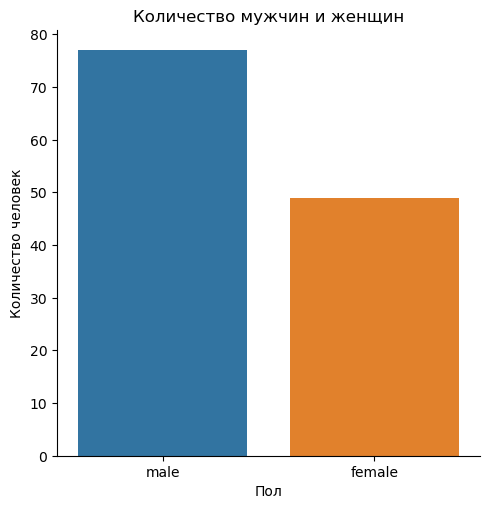

Sex
male      77
female    49
Name: count, dtype: int64

In [10]:
sns.catplot(data=errors.query("y_true != y_pred"), x="Sex", kind="count")

plt.title("Количество мужчин и женщин")
plt.xlabel("Пол")
plt.ylabel("Количество человек")

plt.show()

display(errors.query("y_true != y_pred").Sex.value_counts())

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

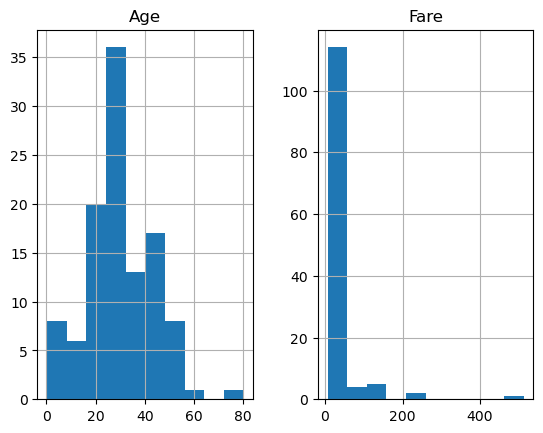

In [18]:
errors.query("y_true != y_pred")[['Age', 'Fare']].hist(bins=10)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

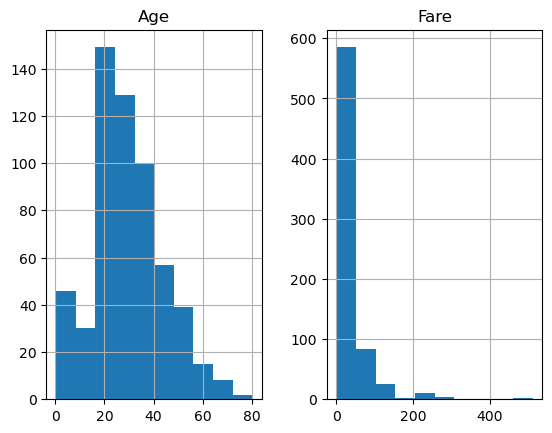

In [19]:
X_train[['Age', 'Fare']].hist(bins=10)